Finalised mass model with multi-step fits. Generate random perturbed datasets with combinatorial background "removed". 

1. Define fit functions 
2. Extract J/Psi control channel from total dataset 
3. Fit all parameters (2-step, bg then total) 
4. Fine tune sigma with scaling factor using simulated signal dataset 
5. Fit amplitude over classified dataset 
6. Calculate fit yields 
7. Define function to calculate acceptance percentage at q2 and B0 mass 
8. Generate multiple datasets 

In [1]:
import scipy as sp
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from uncertainties import ufloat

In [2]:
from selection_criteria.functions import cut_data
import crystal_ball as cry

## import data

In [3]:
## total dataset (to get J/Psi)
data_path = '../data/'
total_path = f'{data_path}total_dataset.pkl'
total_dataset_jpsi = pd.read_pickle(total_path)

len(total_dataset_jpsi)

498245

In [4]:
cut_q2 = [[0.98,1.10],[8.,11.],[12.5,15.]]
def selection_7(data, cut_q2=cut_q2):
    return cut_data(data, cut_q2)

total_dataset_jpsi = selection_7(total_dataset_jpsi, cut_q2=[cut_q2[1]]) # only keep J/Psi dominated regions
len(total_dataset_jpsi)

123717

In [5]:
## signal 
signal_path = f'{data_path}signal.pkl'
signal = pd.read_pickle(signal_path)

In [6]:
## classified dataset 
data_folder = './final_data_processed/'
total_dataset = pd.read_pickle(f'{data_folder}/total_dataset_classified.pkl')

## helper functions

In [7]:
## q2 functions
from data_loader import extract_bin_number, q2_ranges
q2_bins = q2_ranges

In [8]:
## fit functions

def crystal_ball_norm(m, mu, sigma, alpha, n):
    abs_alpha = abs(alpha)
    
    a = (n/abs_alpha)**n * np.exp(-0.5*alpha**2)
    b = n/abs_alpha - abs_alpha
    
    d = np.sqrt(np.pi/2) * (1 + erf(abs_alpha / np.sqrt(2)))
    e = n * np.exp(-abs_alpha**2 / 2) / abs_alpha / (n-1)
    A = 1 / sigma / (d + e)

    x = (m-mu)/sigma
    c = -abs(alpha)
    
    return np.piecewise(x, [x > c, x <= c], 
                [lambda x: A * np.exp(-0.5*(x)**2),
                 lambda x: A * (a / (b-x)**n)])


def exp_bg(m, B, tau):
    return B * np.exp(-tau*(m-5170))

In [9]:
def signal_model(m, A, mu, sigma1, sigma2, alpha, n, f_core):
    cb1 = crystal_ball_norm(m, mu, sigma1, alpha, n)
    cb2 = crystal_ball_norm(m, mu, sigma2, alpha, n)
    return A * (f_core * cb1 + (1 - f_core) * cb2)


def signal_bg_model(m, A, mu, sigma1, sigma2, alpha, n, f_core, B, tau):
    return signal_model(m, A, mu, sigma1, sigma2, alpha, n, f_core) + exp_bg(m, B, tau)

In [10]:
## pretty print

def pretty_print_coef(A, mu, sigma1, sigma2, alpha, n, f_core, B, tau):
    print(f'mu={mu:.4f}, sigma1={sigma1:.4f}, sigma2={sigma2:.4f}, alpha={alpha:.4f}, n={n:.4f}, f_core={f_core:.4f}')
    print(f'A1={A:.4f}, B={B:.4f}, tau={tau:.4f}')

In [11]:
## plotting

def plot_data(bin_centers, hist, bin_diffs):
    plt.scatter(bin_centers, hist, c='black', s=6)
    plt.errorbar(bin_centers, hist, xerr=bin_diffs/2, yerr=np.sqrt(hist), fmt='none', c='black',
                capsize=2)
    
def plot_bg(x, y):
    plt.plot(x, y, c='red', alpha=0.8)
    plt.fill_between(x, y, 
                     color='red', facecolor='none', alpha=0.7, hatch=r'\\\\')

def plot_signal(x, y):
    plt.plot(x, y, c='blue', alpha=0.6)
    plt.fill_between(x, y, color='blue', alpha=0.3)
    
    
def plot_format():
    plt.ylim([0, None])
    plt.xlim([5170, 5700])
    
    plt.xlabel(r'$m(K^+ \pi^- \mu^+ \mu^-)$ [MeV/$c^2$]')
    plt.ylabel('Candidates')

In [12]:
def save_fig(name):
    plt.savefig('./final_data_processed/crystal_ball_output/' + name + '.pdf')

## fit J/Psi control channel

[3.30034713e+03 4.50402506e-03]


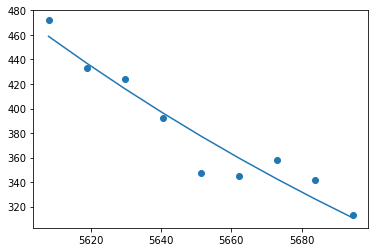

In [13]:
bins = np.linspace(5170,5700,50)
bin_diffs = bins[1] - bins[0]
hist, bin_edges = np.histogram(total_dataset_jpsi['B0_MM'], bins=np.linspace(5170,5700,50))
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

m_cut = bin_centers > 5600

p0 = [hist[m_cut][0], 4e-3]
popt_bg, pcov_bg = curve_fit(exp_bg, bin_centers[m_cut], hist[m_cut], p0=p0)
print(popt_bg)
plt.scatter(bin_centers[m_cut], hist[m_cut])
plt.plot(bin_centers[m_cut], exp_bg(bin_centers[m_cut], *popt_bg))

mu=5280.9430, sigma1=15.0500, sigma2=32.6365, alpha=1.3192, n=5.1963, f_core=0.6944
A1=575161.0116, B=4044.7592, tau=0.0049
mu=0.1982, sigma1=0.4796, sigma2=2.5245, alpha=0.0490, n=1.4302, f_core=0.0491
A1=4379.7381, B=30.9272, tau=0.0000


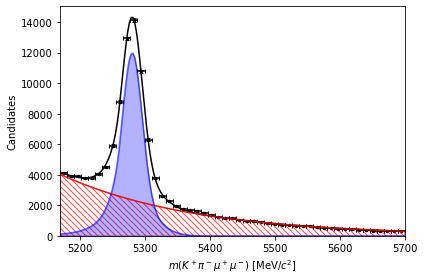

In [14]:
# A, mu, sigma1, sigma2, alpha, n, f_core
p0 = [6e5, 5280, 15, 26, 1.5, 5.2, 0.7, *popt_bg]
bounds = [(-np.inf, np.inf)]*len(p0)
bounds[5] = (3, 5.3)
bounds[6] = (0.5, 1)
xscale = [1e5, 5280, 15, 26, 1.5, 0.2, 0.7, *popt_bg]

popt, pcov = curve_fit(signal_bg_model, bin_centers, hist, p0=p0, absolute_sigma=True,
                       bounds=tuple(zip(*bounds)), method='trf',
                       jac='3-point', x_scale=xscale, loss='soft_l1', max_nfev=len(hist) * 200)

x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
plt.plot(x_fit, signal_bg_model(x_fit, *popt,), c='black')

plot_data(bin_centers, hist, bin_diffs)
plot_bg(x_fit, exp_bg(x_fit, *popt[-2:]))
plot_signal(x_fit, signal_model(x_fit, *popt[:-2]))

plot_format()
plt.tight_layout()
save_fig('JPsi_fit')

pretty_print_coef(*popt)
pretty_print_coef(*list(np.sqrt(np.diag(pcov))))

## fine tune sigma for signal simulation

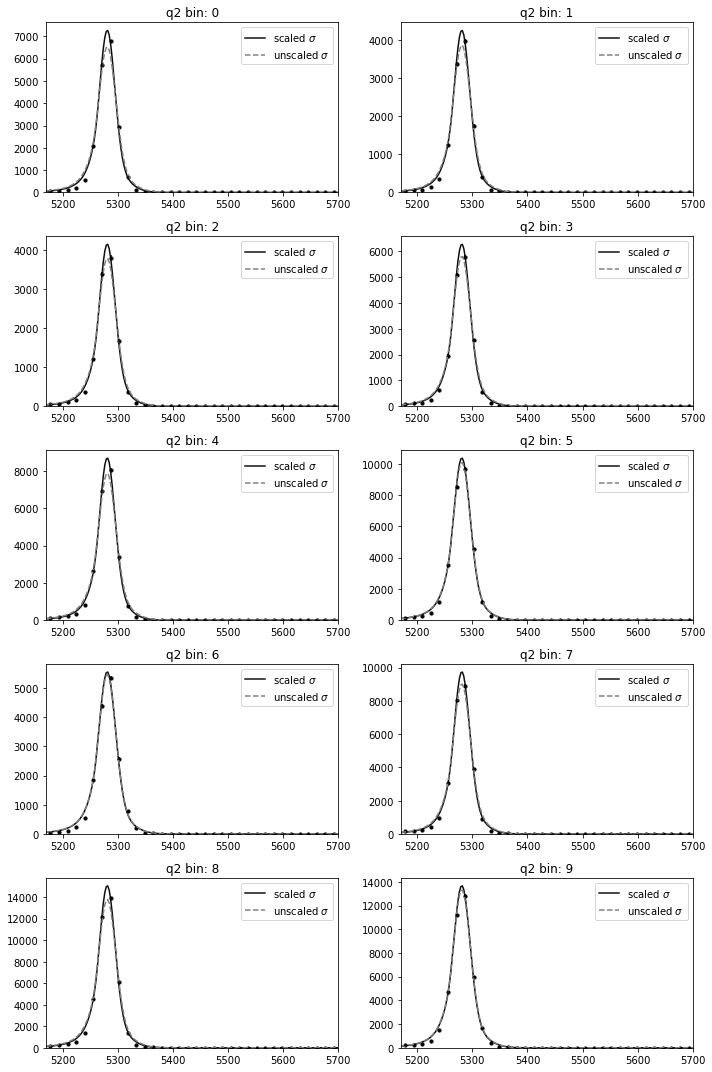

In [15]:
sigma_scales = []
sigma_scales_err = []

plt.figure(figsize=(10, 15))
for i in range(10):
    hist, bin_edges = np.histogram(extract_bin_number(signal, i)['B0_MM'], bins=np.linspace(5170,5700,35))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    def normalise_fit_curve(popt):
        popt = np.copy(popt)
        sigma1 = popt[2]
        sigma2 = popt[3]
        def f(m, A, sigma_scale):
            popt[2] = sigma_scale * sigma1
            popt[3] = sigma_scale * sigma2
            
            return A * signal_model(m, *popt[:-2])
        return f
    
    p0 = [0.5, 1]
    popt_norm, pcov_norm = curve_fit(normalise_fit_curve(popt), bin_centers, hist, p0=p0)
    x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
    
    plt.subplot(5, 2, i+1)
    plt.plot(x_fit, normalise_fit_curve(popt)(x_fit, *popt_norm), c='black', alpha=0.95, label=r'scaled $\sigma$')
    
    plt.plot(x_fit, popt_norm[0] * signal_model(x_fit, *popt[:-2]), '--', c='gray', alpha=1, label=r'unscaled $\sigma$')

    sigma_scales.append(popt_norm[1])
    sigma_scales_err.append(np.sqrt(pcov_norm[1][1]))
    
    plt.scatter(bin_centers, hist, c='black', s=10)
    plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), fmt='none', c='black')
    
    plt.title(f'q2 bin: {i}')
    plt.ylim([0, None])
    plt.xlim([5170, 5700])
    plt.legend()
    
plt.tight_layout()
save_fig('signal_sim_scaled')
plt.show()

In [16]:
for i in range(len(sigma_scales)):
    print(f'bin {i}: sigma={sigma_scales[i]:.3f} ± {sigma_scales_err[i]:.3f}')

bin 0: sigma=0.898 ± 0.016
bin 1: sigma=0.908 ± 0.015
bin 2: sigma=0.911 ± 0.012
bin 3: sigma=0.924 ± 0.011
bin 4: sigma=0.905 ± 0.010
bin 5: sigma=0.973 ± 0.011
bin 6: sigma=0.982 ± 0.020
bin 7: sigma=0.924 ± 0.010
bin 8: sigma=0.915 ± 0.012
bin 9: sigma=0.974 ± 0.012


## fit classified dataset

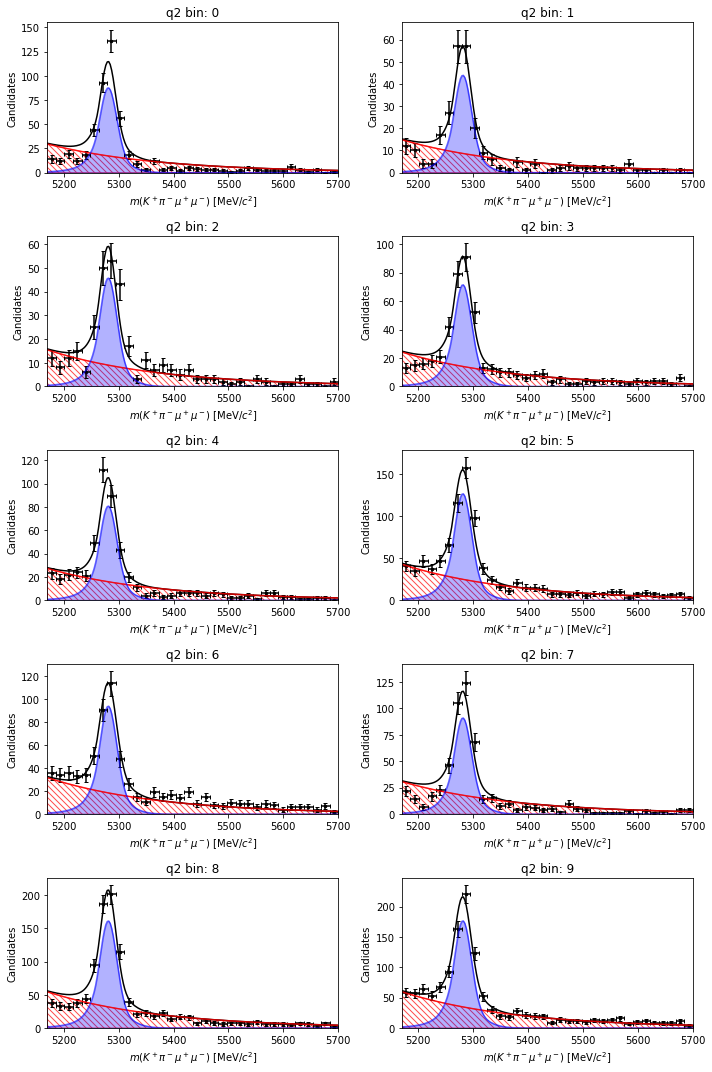

In [17]:
plt.figure(figsize=(10, 15))
for i in range(10):
    bins = np.linspace(5170,5700,35)
    bin_diffs = bins[1] - bins[0]
    hist, bin_edges = np.histogram(extract_bin_number(total_dataset, i)['B0_MM'], bins=bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    def normalise_fit_curve(popt):
        popt = np.copy(popt)
        sigma1 = popt[2]
        sigma2 = popt[3]
        def f(m, A):
            popt[2] = sigma_scales[i] * sigma1
            popt[3] = sigma_scales[i] * sigma2
            return A * signal_bg_model(m, *popt)
        return f
    
#     sigma = np.sqrt(hist)
#     below_zero = sigma == 0
#     sigma[below_zero] = np.min(sigma[below_zero])
    popt_norm, pcov_norm = curve_fit(normalise_fit_curve(popt), bin_centers, hist,)# sigma=sigma,
#                                      method='trf', loss='soft_l1')

    plt.subplot(5, 2, i+1)
    plt.title(f'q2 bin: {i}')
    
    x_fit = np.linspace(np.min(bin_edges), np.max(bin_edges), 200)
    plt.plot(x_fit, normalise_fit_curve(popt)(x_fit, *popt_norm), c='black')
    
    plot_data(bin_centers, hist, bin_diffs)
    plot_bg(x_fit, popt_norm[0] * exp_bg(x_fit, *popt[-2:]))
    plot_signal(x_fit, popt_norm[0] * signal_model(x_fit, *popt[:-2]))
    
    plot_format()
    
plt.tight_layout()
save_fig('total_classified_fit')
plt.show()

## fit yields 

In [119]:
popt, sigma_scales

(array([5.75161012e+05, 5.28094304e+03, 1.50499661e+01, 3.26365448e+01,
        1.31915667e+00, 5.19633891e+00, 6.94406182e-01, 4.04475924e+03,
        4.86919001e-03]),
 [0.8977350026150787,
  0.9082845138445003,
  0.9113461532571537,
  0.924136636507419,
  0.9045389509088417,
  0.9727461704603207,
  0.9821860687487115,
  0.9241164706696331,
  0.9146883378208498,
  0.9735704017895704])

In [120]:
signal_model, exp_bg

(<function __main__.signal_model(m, A, mu, sigma1, sigma2, alpha, n, f_core)>,
 <function __main__.exp_bg(m, B, tau)>)

In [126]:
m_min, m_max = 5170, 5700

def add_sigma_scales(popt):
    popt = np.copy(popt)
    sigma1 = popt[2]
    sigma2 = popt[3]
    def f(m, i):
        popt[2] = sigma_scales[i] * sigma1
        popt[3] = sigma_scales[i] * sigma2
        return signal_model(m, *popt[:-2])
    return f
signal_model_scaled = add_sigma_scales(popt)

total_signal = 0
total_bg = 0
for i in range(10):
    signal_area = quad(lambda m: signal_model_scaled(m, i), m_min, m_max)
    bg_area = quad(lambda m: exp_bg(m, *popt[-2:]), m_min, m_max)
    signal_area = ufloat(*signal_area)
    bg_area = ufloat(*bg_area)
    
    f_signal = signal_area / (bg_area + signal_area)
    f_bg = bg_area / (bg_area + signal_area)
    
    n_signal = f_signal * len(extract_bin_number(total_dataset, i))
    n_bg = f_bg * len(extract_bin_number(total_dataset, i))
    
    total_signal += n_signal
    total_bg += n_bg
    
    print(f'{f_signal*100:.3f}%, {n_signal:.3f}, {n_bg:.3f}')
    
print()
print(f'total: signal={total_signal:.3f}, bg={total_bg:.3f}')

42.648+/-0.000%, 214.948+/-0.000, 289.052+/-0.000
42.643+/-0.000%, 111.298+/-0.000, 149.702+/-0.000
42.641+/-0.000%, 135.599+/-0.000, 182.401+/-0.000
42.634+/-0.000%, 203.792+/-0.000, 274.208+/-0.000
42.645+/-0.000%, 219.621+/-0.000, 295.379+/-0.000
42.607+/-0.000%, 389.852+/-0.000, 525.148+/-0.000
42.601+/-0.000%, 314.397+/-0.000, 423.603+/-0.000
42.634+/-0.000%, 230.651+/-0.000, 310.349+/-0.000
42.639+/-0.000%, 450.698+/-0.000, 606.302+/-0.000
42.606+/-0.000%, 547.491+/-0.000, 737.509+/-0.000

total: signal=2818.348+/-0.000, bg=3793.652+/-0.000


In [128]:
# fraction at each bin 
bins = np.linspace(5170,5700,35)
bin_centers = (bins[1:] + bins[:-1]) / 2

for x in bin_centers:
    s = signal_model(x, *popt[:-2])
    b = exp_bg(x, *popt[-2:])
    print(f'm={x:.3f}, {s / (s+b)*100:.3f}%')

m=5177.794, 3.923%
m=5193.382, 6.725%
m=5208.971, 11.906%
m=5224.559, 21.535%
m=5240.147, 38.390%
m=5255.735, 60.963%
m=5271.324, 80.277%
m=5286.912, 83.018%
m=5302.500, 70.997%
m=5318.088, 43.768%
m=5333.676, 23.795%
m=5349.265, 11.807%
m=5364.853, 4.520%
m=5380.441, 1.317%
m=5396.029, 0.299%
m=5411.618, 0.053%
m=5427.206, 0.008%
m=5442.794, 0.001%
m=5458.382, 0.000%
m=5473.971, 0.000%
m=5489.559, 0.000%
m=5505.147, 0.000%
m=5520.735, 0.000%
m=5536.324, 0.000%
m=5551.912, 0.000%
m=5567.500, 0.000%
m=5583.088, 0.000%
m=5598.676, 0.000%
m=5614.265, 0.000%
m=5629.853, 0.000%
m=5645.441, 0.000%
m=5661.029, 0.000%
m=5676.618, 0.000%
m=5692.206, 0.000%


## mass model acceptance %

In [134]:
list(zip(range(len(q2_ranges)), q2_ranges))

[(0, (0.1, 0.98)),
 (1, (1.1, 2.5)),
 (2, (2.5, 4.0)),
 (3, (4.0, 6.0)),
 (4, (6.0, 8.0)),
 (5, (15.0, 17.0)),
 (6, (17.0, 19.0)),
 (7, (11.0, 12.5)),
 (8, (1.0, 6.0)),
 (9, (15.0, 17.9))]

In [136]:
q2_bins_ordered = q2_ranges[0:5] + [q2_ranges[7]] + q2_ranges[5:7]
q2_bins_mapping = {i: i for i in range(len(q2_bins_ordered))}
q2_bins_mapping[5] = 7
q2_bins_mapping[6] = 5
q2_bins_mapping[7] = 6

def find_bin_number(q2):
    for i in range(len(q2_bins_ordered)):
        a, b = q2_bins_ordered[i]
        if q2 >= a and q2 <= b:
            return q2_bins_mapping[i]
    return -1

In [138]:
def calc_p_signal(q2, m):
    i = find_bin_number(q2)
    s = signal_model_scaled(m, i)
    b = exp_bg(m, *popt[-2:])
    return s / (s + b)

## generate mass selection datasets

In [173]:
f_dir = './final_data_processed/crystal_ball_selections/'
def save_df(fn, data):
    # only save needed columns
    data = data[['B0_MM', 'Kstar_MM', 'J_psi_MM', 'q2', \
                 'phi', 'costhetal', 'costhetak', 'p_signal']]
    data.to_pickle(f_dir + fn + '.pkl')

In [174]:
def f(x):
    return calc_p_signal(x['q2'], x['B0_MM'])
total_dataset['p_signal'] = total_dataset.apply(f, axis=1)
total_dataset['p_signal'].describe()

count    4.973000e+03
mean     4.424796e-01
std      3.497565e-01
min      8.095656e-42
25%      4.108625e-02
50%      5.152104e-01
75%      8.062375e-01
max      8.501990e-01
Name: p_signal, dtype: float64

In [181]:
rng = np.random.default_rng(42)

for i in range(40):
    p = rng.random(len(total_dataset))
    data_selected = total_dataset[total_dataset['p_signal'] > p]
    save_df(f'total_classified_dataset{i:02}', data_selected)